# Intro


_Word embedding_ is a mapping of words (or phrases) from the vocabulary to vectors of real numbers.

### Suggested readings:
* To understand better Skip-Gram Model the following tutorial is suggested
 - [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

* To know about more complex and effective implementations of word2vec models see

 - [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

In [543]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
%matplotlib inline


# Lets for example consider a simple way to map words from sentences into dense vectors.
# Lets make a table with words coocurrencies and then project vectors of all words into 2D using PCA.

s = ['Sky is blue', 'She is getting better', 'Everything is possible']
dic = defaultdict(dict)
for sent in s:
    words = sent.split()
    for w in words:
        for w2 in words:
            dic[w][w2]=1

df = pd.DataFrame(dic)
df.fillna(0, inplace=True)
df


,Everything,She,Sky,better,blue,getting,is,possible
Everything,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0
She,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
Sky,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0
better,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
blue,0.0,0.0,1.0,0.0,1.0,0.0,1,0.0
getting,0.0,1.0,0.0,1.0,0.0,1.0,1,0.0
is,1.0,1.0,1.0,1.0,1.0,1.0,1,1.0
possible,1.0,0.0,0.0,0.0,0.0,0.0,1,1.0


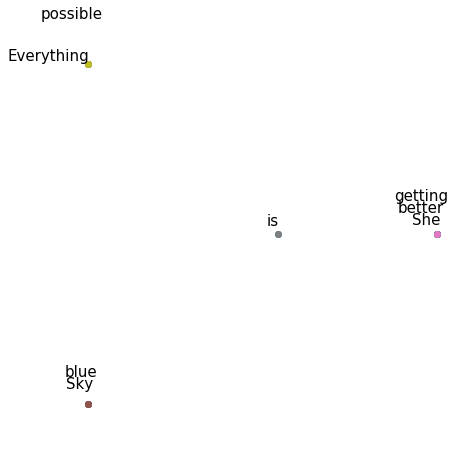

In [544]:
res = PCA().fit_transform(df)

font = {'size'   : 15}
plt.rc('font', **font)
plt.figure(figsize=(7,7))
plt.scatter(res[:,0], res[:,1])
plt.axis('off')
for i, label in enumerate(df.columns):
    x, y = res[i,0], res[i,1]
    plt.scatter(x, y)
    annot = {'has': (1, 50), 'is': (1, 5)}
    plt.annotate(label, xy=(x, y),
                 xytext=annot.get(label,(1+i*2, 6*i)), 
                 textcoords='offset points',
                   ha='right', va='bottom', )

# word2vec: skip gram & cbow

Models __CBOW (Continuous Bag of Words)__ and __Skip gram__ were invented in the now distant 2013,
*article*:
[*Tomas Mikolov et al.*](https://arxiv.org/pdf/1301.3781v3.pdf)

* __CBOW__ model predict missing word (focus word) using context (surrounding words).
* __skip gram__ model is reverse to _CBOW_. It predicts context based on the word in focus.

* **Context** is a fixed number of words to the left and right of the word in focus (see picture below). The length of the context is defined by the "window" parameter.

![context](pics/context.png)

Two models comparision

![architecture](pics/architecture.png)

___

There are a lot of implementations of word2vec e.g.[gensim](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb).
And there are a lot of trained word-vectors which are already ready to use.
___


### Skip_gram

Consider a corpus with a sequence of words $ w_1, w_2, .., w_T $.

Objective function (we would like to maximize it) for _skip gram_ is defined as follow:


$$ AverageLogProbability = \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leqslant j\leqslant c, j \neq 0} log\ p (w_{t+j} | w_t) $$

* where $ c $ is a context length.
* $w_t$ -- focus word

The basic formulation for probability $ p (w_{t+j} | w_t) $ is calculated using __Softmax__ -

$$ p (w_h | w_i) = \frac{exp(s(v_i, v_h))}{ \sum^{W}_{w=1}  exp(s(v_{w}, v_{i} )) } $$

where
* $w_i$ -- input focus word
* $w_h$ -- hypothetically context word for a given focus word $w_i$
* $v_i$ and $v_h$ input-word and hypothesis-word vector representations (for $w_i$, $w_h$)
* $s(v_i, v_h) = v^{T} _{h} \cdot v_{i}$
* $W$ is the number of words in vocabulary

___

### CBOW

Predict word using context.

$$ E = -log\ p(w_h\ |\ w_{1},\ w_{2},\ \dots,\ w_{c}) $$


The **probability** is the same as in the *skip gram* model, but now $v_i$ is a sum of context-word vectors.

$$ p(w_h\ |\ w_{1},\ w_{2},\ \dots,\ w_{c})  = \frac{exp(s(v_i, v_h))}{\sum^{W}_{w=1}  exp(s(v_{w}, v_{i}))} $$


* $\ w_{1},\ w_{2},\ \dots,\ w_{c}$ -- input context words
* $w_h$ -- hypothetically focus word for a given context words
* $ v_i = \sum^{c}_{k=1} w_{k}$
* $ v_h$ = vector of hypothesis word
* $s(v_i, v_h) = v^{T} _{h} \cdot v_{i}$
* $W$ is the number of words in vocabulary

___

Lets implement __`CBOW`__ using tf framework.

And then implement __`skip gram`__ using CBOW implementation as an example.
___

In [545]:
import tensorflow as tf

Using [text8 dataset](http://mattmahoney.net/dc/textdata),

It's a 100 Mb dump of English Wiki at the time of March 3, 2006.

# Working with data

It's not so interesting to explore this code.

Truly, all the dirty work is done for you.:3

In [546]:
# WARNING! if this file "./data/text8.zip" doesn't exist
# it will be downloaded right now.

import os, urllib.request
def fetch_data(url):
    
    filename = url.split("/")[-1]
    datadir = os.path.join(os.getcwd(), "data")
    filepath = os.path.join(datadir, filename)
    
    if not os.path.exists(datadir):
        os.makedirs(datadir)
    if not os.path.exists(filepath):
        urllib.request.urlretrieve(url, filepath)
    
    return filepath

url = "http://mattmahoney.net/dc/text8.zip"
filepath = fetch_data(url)
print ("Data at {0}.".format(filepath))

Data at /home/roman/prj/nlp_mipt/seminar02/data/text8.zip.


In [547]:
# Unzip and read data

import os, zipfile

def read_data(filename):
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


words = read_data(filepath)
print("data_size = {0}".format(len(words)))

data_size = 17005207


In [548]:
# Only N = 50000 the most frequent words is considered
# The other marked with token `UNK` (unknown)

from collections import Counter

def build_dataset(words, vocabulary_size):
    count = [[ "UNK", -1 ]]
    count.extend(Counter(words).most_common(vocabulary_size-1))
    print("Least frequent word: ", count[-1])
    word_to_index = { word: i for i, (word, _) in enumerate(count) }
    data = [word_to_index.get(word, 0) for word in words] # map unknown words to 0
    unk_count = data.count(0) # Number of unknown words
    count[0][1] = unk_count
    index_to_word= dict(zip(word_to_index.values(), word_to_index.keys()))
    
    return data, count, word_to_index, index_to_word

vocabulary_size = 50000
data, count, word_to_index, index_to_word = build_dataset(words, vocabulary_size)

# Everything you need to know about the dataset

print("data: {0}".format(data[:10]))
print("count: {0}".format(count[:10]))
print("word_to_index: {0}".format(list(word_to_index.items())[:10]))
print("index_to_word: {0}".format(list(index_to_word.items())[:10]))

Least frequent word:  ('microkernels', 9)
data: [5237, 3084, 12, 6, 195, 2, 3136, 46, 59, 156]
count: [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
word_to_index: [('obfuscation', 47961), ('emmett', 34377), ('furtherance', 44073), ('faded', 12694), ('substituted', 10433), ('halo', 11384), ('flick', 30107), ('shrapnel', 28979), ('reilly', 13020), ('flatten', 43495)]
index_to_word: [(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


In [549]:
import numpy as np
from collections import deque

def generate_batch(data_index, data_size, batch_size, bag_window):
    span = 2 * bag_window + 1 # [ bag_window, target, bag_window ]
    batch = np.ndarray(shape = (batch_size, span - 1), dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    
    data_buffer = deque(maxlen = span)
    
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
        
    for i in range(batch_size):
        data_list = list(data_buffer)
        labels[i, 0] = data_list.pop(bag_window)
        batch[i] = data_list
        
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print("data = {0}".format([index_to_word[each] for each in data[:16]]))
data_index, data_size, batch_size = 0, len(data), 4
for bag_window in [1, 2]:
    _, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
    print("bag_window = {0}".format(bag_window))
    print("batch = {0}".format([[index_to_word[index] for index in each] for each in batch]))
    print("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(4)]))

data = ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']
bag_window = 1
batch = [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
labels = ['originated', 'as', 'a', 'term']

bag_window = 2
batch = [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
labels = ['as', 'a', 'term', 'of']



And now just take a close look at the output.

* We just want to implement _CBOW_, and therefore missed words are considered as the `labels`.

* Remember about the __window__ parameter discussed above, here it is __`bag_window`__.

* Each sample in the batch has a number of words equal to __`bag_window * 2`__
___

# CBOW architecture


In [550]:
import math

USE_NCE = False

DEVICE_NAME = "/cpu:0"

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    with tf.device(DEVICE_NAME):
        if USE_NCE:
            # https://github.com/tensorflow/tensorflow/blob/r1.3/tensorflow/examples/tutorials/word2vec/word2vec_basic.py
            num_sampled = 64
            embedding_size = 128
            batch_size = 128
            bag_window = 1

            train_data = tf.placeholder(tf.int32, [batch_size, bag_window * 2])
            train_labels = tf.placeholder(tf.int32, [batch_size, 1])

            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_data)
            context_sum = tf.reduce_mean(embed, axis=1)
            
            nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                stddev=1.0 / math.sqrt(embedding_size)))
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

            # Compute the average NCE loss for the batch.
            # tf.nce_loss automatically draws a new sample of the negative labels each
            # time we evaluate the loss.
            loss = tf.reduce_mean(
                tf.nn.nce_loss(
                    weights=nce_weights,
                    biases=nce_biases,
                    inputs=context_sum,
                    labels=train_labels,
                    num_sampled=num_sampled,
                    num_classes=vocabulary_size))
            optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
        else:
            # define constants
            batch_size = 128
            embedding_size = 64
            bag_window = 1 # 2 # How many words to consider from each side

            # Take the vectors for the context words, which are all bag_window * 2
            train_data = tf.placeholder(tf.int32, [batch_size, bag_window * 2])
            # Label -- is a word in focus
            train_labels = tf.placeholder(tf.int32, [batch_size, 1])

            # Create an embedding matrix
            # and initialize it by sampling from the uniform distribution [-1, 1]
            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

            # Get vectors corresponding to the indices of context words
            # embed is a matrix with shape [batch_size, bag_window * 2, embedding_size]
            embed = tf.nn.embedding_lookup(embeddings, train_data)

            # Sum up all the context vectors to the one vector with the same dimension
            # Here we got a matrix of such vectors with the shape [batch_size, embedding_size]
            context_sum = tf.reduce_mean(embed, axis=1)

            # s function from theory above
            # <use tf.matmul to compute scores for context_sum and embeddings>
            scores = tf.matmul(context_sum, embeddings, transpose_b = True)

            # <make labels one-hot; use tf functions>
            one_hot_labels = tf.one_hot(indices = train_labels, depth = vocabulary_size)
            # <implement softmax loss with cross entropy>
            loss_tensor = tf.nn.softmax_cross_entropy_with_logits(
                labels = one_hot_labels,
                logits = scores
            )
            # <your loss here>
            loss = tf.reduce_mean(loss_tensor)
            optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

        # We need to normalize word embeddings for dot product to be a cosine distance 
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True))
        normalized_embeddings = embeddings / norm

# Optional

You may use [NCE(Noise Contrastive Estimation)](https://www.tensorflow.org/api_docs/python/tf/nn/nce_loss) loss instead of softmax with cross entropy.

Just try to make some experiments.

Using NCE will accelerate training at times.

For more details see the [original article](http://papers.nips.cc/paper/5165-learning-word-embeddings-efficiently-with-noise-contrastive-estimation.pdf).

# Let's train

In [551]:
%%time
num_steps = 100000 if USE_NCE else 3000 
from IPython.display import clear_output

with tf.Session(graph=graph) as sess:
    with tf.device(DEVICE_NAME):
        try:
            tf.global_variables_initializer().run()
            print('Initialized')
            average_loss = 0

            for step in range(num_steps+1):
                data_index, batch, labels = generate_batch(data_index, data_size, batch_size, bag_window)
                feed_dict = { train_data: batch, train_labels: labels }
                _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
                average_loss += current_loss
                if step % 100 == 0:
                    if step > 0:
                        average_loss = average_loss / 100
                        clear_output(True)
                        print ("step = {0}, average_loss = {1}".format(step, average_loss))
                        average_loss = 0
        except KeyboardInterrupt:
            final_embeddings = normalized_embeddings.eval()
        final_embeddings = normalized_embeddings.eval()

step = 3000, average_loss = 7.778428392410278
CPU times: user 1h 18min 4s, sys: 3min 11s, total: 1h 21min 15s
Wall time: 10min 54s


# Visualization

[Use projector](http://projector.tensorflow.org/)

In [552]:
# Use these files for Projector
with open('embeddings.txt', 'w') as f:
    for n in range(vocabulary_size):
        s = '\t'.join([index_to_word[n]] + [str(num) for num in final_embeddings[n]])
        f.write(s + '\n')
with open('metadata.txt', 'w') as f:
    for n in range(vocabulary_size):
        f.write(index_to_word[n] + '\n')

Or see TSNE here:

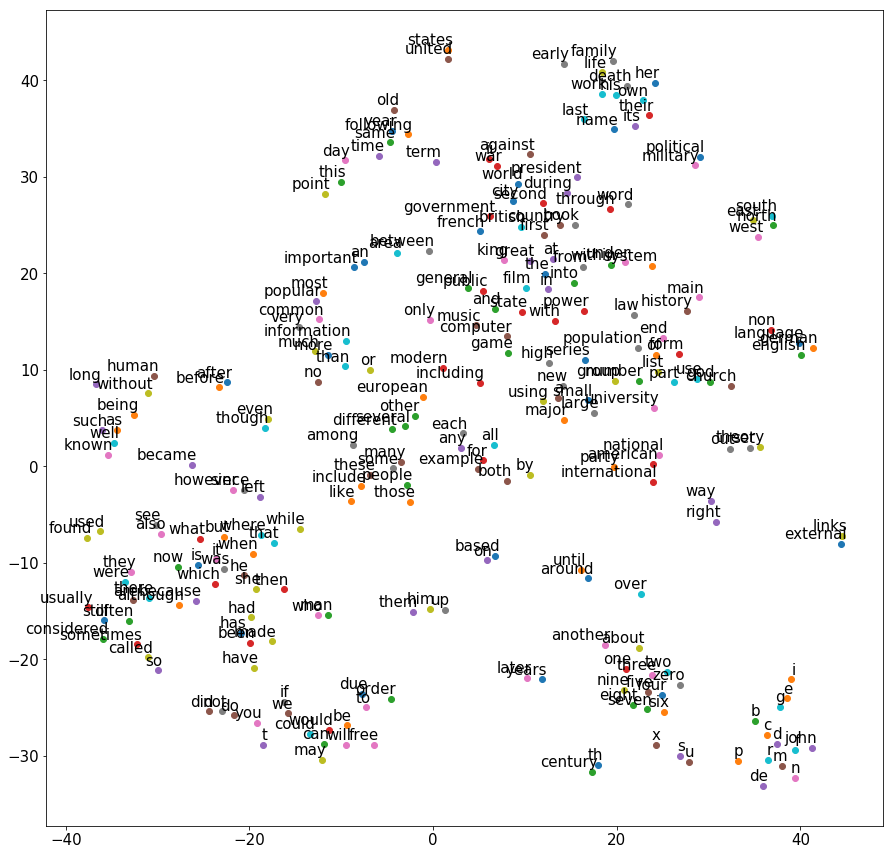

In [553]:
from sklearn.manifold import TSNE

num_points = 250

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

plt.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

# Test similarities of our embeddings with gensim

In [554]:
# This file for Gensim .c (.vec) format

def create_vec_file(final_emb_mtx, vocab_size, vec_size,filename):
    with open(filename, 'w') as f:
        f.write(str(vocab_size)+' '+str(vec_size) + '\n')
        for n in range(vocab_size):
            s = ' '.join([index_to_word[n]] + [str(num) for num in final_emb_mtx[n]])
            f.write(s + '\n')
            
create_vec_file(final_embeddings, vocab_size=vocabulary_size, vec_size=embedding_size, filename='simple_cbow.vec')

In [555]:
from gensim.models import KeyedVectors

simple_cbow = KeyedVectors.load_word2vec_format('simple_cbow.vec', binary=False)

In [556]:
# Pick a word 
find_similar_to = ['five','many','people','their','often', 'when', 'september', 'left', 'game', 'mit', 'west', 'car']

# Finding out similar words [default= top 10]
table = defaultdict(dict)
for target in find_similar_to:
    sw = simple_cbow.similar_by_word(target)
    for i in range(min(7,len(sw))):
        table[i+1][target] = "{0}: {1:.2f}".format(*sw[i])

df = pd.DataFrame(table)
df.fillna(0, inplace=True)
df

,1,2,3,4,5,6,7
car,luxury: 0.72,world: 0.70,first: 0.69,continent: 0.69,the: 0.69,city: 0.68,company: 0.66
five,seven: 0.95,four: 0.94,eight: 0.93,three: 0.93,six: 0.93,two: 0.90,nine: 0.87
game,arcade: 0.76,video: 0.73,games: 0.68,animation: 0.62,computer: 0.61,macintosh: 0.61,introduced: 0.60
left,since: 0.68,he: 0.66,was: 0.66,it: 0.66,built: 0.65,had: 0.64,himself: 0.64
many,aircraft: 0.82,some: 0.79,cars: 0.79,people: 0.74,asteroids: 0.73,these: 0.72,for: 0.72
mit,researcher: 0.51,aardwolf: 0.41,records: 0.40,squid: 0.39,prakrit: 0.39,dingo: 0.39,boa: 0.39
often,are: 0.81,sometimes: 0.76,commonly: 0.76,used: 0.75,widely: 0.75,called: 0.74,still: 0.73
people,many: 0.74,men: 0.72,some: 0.71,aircraft: 0.69,cars: 0.69,those: 0.65,scientists: 0.64
september,april: 0.82,january: 0.81,june: 0.81,july: 0.81,december: 0.80,on: 0.76,november: 0.76
their,own: 0.84,its: 0.81,his: 0.74,design: 0.73,inspiration: 0.69,with: 0.69,for: 0.68


# Task

Your task is to implement `skip-gram` model, using code above.

This approach is nicely illustrated with this figure:

![skip_gram](pics/training_data.png)
As you can see on the picture, the training set consists of pairs (`central word`, `context word`).

I.e. our model takes `central word` and should produce class in softmax, which corresponds to `context word`.

The difference between two models is not that big after all, so good luck with coding!

In [571]:
from collections import deque
import numpy as np
import random

def generate_batch_2(data_index, data_size, batch_size, num_skips, skip_window):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape = batch_size, dtype = np.int32)
    labels = np.ndarray(shape = (batch_size, 1), dtype = np.int32)
    span = 2 * skip_window + 1
    data_buffer = deque(maxlen = span)
    for _ in range(span):
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    
    for i in range(batch_size // num_skips):
        target, targets_to_avoid = skip_window, [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid: 
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = data_buffer[skip_window]
            labels[i * num_skips + j, 0] = data_buffer[target]
        data_buffer.append(data[data_index])
        data_index = (data_index + 1) % data_size
    return data_index, batch, labels


print ("data = [{0}]\n".format(" ".join([index_to_word[each] for each in data[:32]])))
data_index, data_size = 0, len(data)
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    data_index, batch, labels = generate_batch_2(data_index=data_index, 
                                               data_size=data_size, 
                                               batch_size=16, 
                                               num_skips=num_skips, 
                                               skip_window=skip_window)
    print ("data_index = {0}, num_skips = {1}, skip_window = {2}".format( data_index, num_skips, skip_window))
    print ("batch = {0}".format([index_to_word[each] for each in batch]))
    print ("labels = {0}\n".format([index_to_word[each] for each in labels.reshape(16)]))

data = [anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans UNK of the french revolution whilst the term]

data_index = 11, num_skips = 2, skip_window = 1
batch = ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
labels = ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'of', 'a', 'abuse', 'term', 'of', 'first', 'used', 'abuse', 'against', 'first']

data_index = 9, num_skips = 4, skip_window = 2
batch = ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
labels = ['originated', 'a', 'anarchism', 'term', 'of', 'originated', 'as', 'term', 'a', 'of', 'as', 'abuse', 'first', 'term', 'a', 'abuse']



# Tensorflow code for skip-gram model

In [558]:
import math

batch_size = 128
embedding_size = 64
DEVICE_NAME = "/cpu:0"
USE_NCE = True # False

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    with tf.device(DEVICE_NAME):
        if USE_NCE:
            num_sampled = 64
            embedding_size = 96

            train_data = tf.placeholder(tf.int32, [batch_size], 'input')
            train_labels = tf.placeholder(tf.int32, [batch_size, 1], 'labels')

            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')
            embed = tf.nn.embedding_lookup(embeddings, train_data, name='embed')
            
            nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                stddev=1.0 / math.sqrt(embedding_size)), 'nce_weights')
            nce_biases = tf.Variable(tf.zeros([vocabulary_size]), 'nce_biases')
            
            loss = tf.reduce_mean(
                tf.nn.nce_loss(
                    weights=nce_weights,
                    biases=nce_biases,
                    inputs=embed,
                    labels=train_labels,
                    num_sampled=num_sampled,
                    num_classes=vocabulary_size, name='nce_loss'))
            optimizer = tf.train.GradientDescentOptimizer(.3).minimize(loss)
        else:
            train_data = tf.placeholder(tf.int32, [batch_size], name='inputs')
            train_labels = tf.placeholder(tf.int32, [batch_size, 1], name='labels')

            embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
            embed = tf.nn.embedding_lookup(embeddings, train_data)
            scores = tf.matmul(embed, embeddings, transpose_b = True)

            loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(
                    labels = tf.one_hot(train_labels, vocabulary_size),
                    logits = scores
                ), 'loss')
            optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims = True), 'norm')
        normalized_embeddings = embeddings / norm

### Training skip-gram model

In [559]:
%%time
num_steps = 200000 if USE_NCE else 10000 
from IPython.display import clear_output

num_skips = 2
skip_window = 1

with tf.Session(graph=graph) as sess:
    with tf.device(DEVICE_NAME):
        try:
            tf.global_variables_initializer().run()
            print('Initialized')
            average_loss = 0

            for step in range(num_steps+1):
                data_index, batch, labels = generate_batch_2(
                    data_index=data_index, 
                    data_size=data_size, 
                    batch_size=batch_size, 
                    num_skips=num_skips, 
                    skip_window=skip_window)
                feed_dict = { train_data: batch, train_labels: labels }
                _, current_loss = sess.run([optimizer, loss], feed_dict = feed_dict)
                average_loss += current_loss
                every = num_steps//100
                if step % every == 0:
                    if step > 0:
                        average_loss = average_loss / every
                        clear_output(True)
                        print ("step = {0}, average_loss = {1}".format(step, average_loss))
                        average_loss = 0
        except KeyboardInterrupt:
            final_embeddings = normalized_embeddings.eval()
        final_embeddings = normalized_embeddings.eval()

step = 200000, average_loss = 4.7732277805805206
CPU times: user 8min 4s, sys: 33.9 s, total: 8min 38s
Wall time: 3min 47s


### tSNE visualization of embeddings

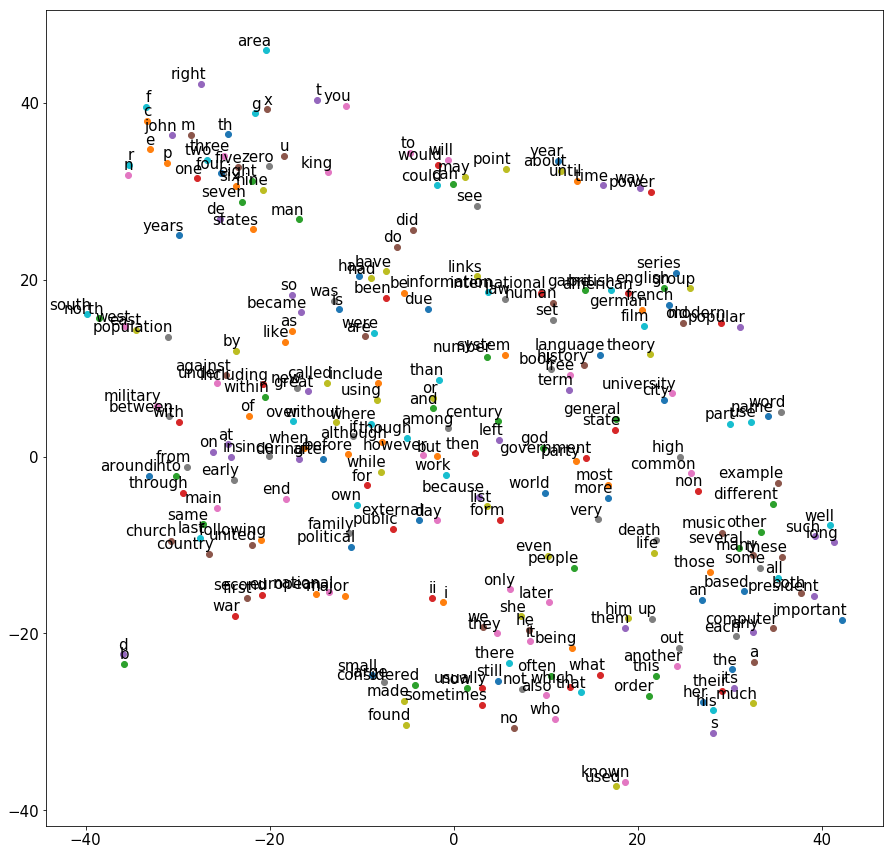

In [560]:
from sklearn.manifold import TSNE

num_points = 250

tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

plt.figure(figsize=(15,15))
words = [index_to_word[i] for i in range(1, num_points+1)]

for i, label in enumerate(words):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()

### Gensim similarity

In [561]:
create_vec_file(
    final_embeddings, 
    vocab_size=vocabulary_size, 
    vec_size=embedding_size, 
    filename='simple_skipgram.vec')

simple_cbow = KeyedVectors.load_word2vec_format('simple_skipgram.vec', binary=False)

table = defaultdict(dict)
for target in find_similar_to:
    sw = simple_cbow.similar_by_word(target)
    for i in range(min(7,len(sw))):
        table[i+1][target] = "{0}: {1:.2f}".format(*sw[i])

df = pd.DataFrame(table)
df.fillna(0, inplace=True)
df

,1,2,3,4,5,6,7
car,attila: 0.59,keep: 0.57,kilometres: 0.56,flag: 0.55,voices: 0.55,entered: 0.54,chronicled: 0.54
five,four: 0.89,six: 0.86,three: 0.85,seven: 0.85,eight: 0.83,nine: 0.77,zero: 0.77
game,chester: 0.57,horse: 0.57,panic: 0.56,strain: 0.53,quinn: 0.53,hulled: 0.53,batman: 0.53
left,allowed: 0.58,dagny: 0.57,establishment: 0.56,acronym: 0.55,revived: 0.55,electrodes: 0.54,peasants: 0.54
many,some: 0.74,several: 0.72,other: 0.57,these: 0.56,predicate: 0.56,all: 0.55,their: 0.55
mit,ayman: 0.62,enters: 0.59,alps: 0.59,agassi: 0.59,prefecture: 0.56,bicameral: 0.55,anus: 0.55
often,which: 0.62,generally: 0.61,usually: 0.59,supposed: 0.57,today: 0.56,now: 0.56,there: 0.56
people,restructuring: 0.56,airplanes: 0.55,dia: 0.54,welsh: 0.54,finished: 0.53,kubrick: 0.53,equipped: 0.53
september,doctrine: 0.61,directive: 0.59,july: 0.57,quit: 0.57,hydraulic: 0.56,billiards: 0.56,description: 0.56
their,its: 0.76,his: 0.72,her: 0.66,the: 0.65,some: 0.58,another: 0.58,any: 0.55


# fastText

Lets look at the [fastText](https://github.com/facebookresearch/fastTextm) library from Facebook Research.

If you're interested, this is an article about _unsupervised learning_ with fasttext:  [link](https://arxiv.org/pdf/1607.04606v1.pdf).

* It was announced in 2016 and allows you to train embeddings and solve classification tasks. It is able to work with the Out-of-vocabulary words through the n-gram training.

* The library is implemented in C ++. [Python interface](https://pypi.python.org/pypi/fasttext) exists for it, but it is not officially supported. Thus it is not recommended to use it. Instead we will use another python wrapper from Gensim.


* fastText allows you to train embeddings very quickly even for fairly large texts compared to other methods.
* fastText works better than gensim's word2vec on small corpora.
* fastText is not a standalone NLP library; it uses other libraries for preprocessing.


The approach to learning attachments from fastText is slightly different than what was discussed above.

The basis is the same as in [skip gram](#Skip_gram) and [CBOW](#CBOW), but the $s$ function in probability definition in _Softmax_ is slightly different.

Let $ G $ be the set of n-grams that can be obtained from the word $ w $ by selecting n nearest letters. And by the way, lets add special symbols "<" and ">" to the left and right to denote prefixes and suffixes.

Then the partitioning will look like this for n = 3 and w = "< where >" we get the set: "< wh", "whe", "her", "ere", "re>" + the word "where" also included in this set.

Comparing each element $ g \in G $ with its own vector $ z_g $, we obtain the scoring function $ s $, which we will substitute into the _Softmax_ expression (as in [skip gram](# Skip_gram) or [CBOW](# CBOW))

$$ s = \sum_ {g \in G_w} z_g ^ {T} \cdot v_ {c} $$

* $v_c$ -- is a vector of word to compare with

Vectors for out-of-vocabulary words could be obtained as a sum of n-gram vectors.

---

There are two ways of fastText usage.
First way --
# Training fastText just from cmd

The first thing to do fastText installation:

In [510]:
!cd ~/prj; git clone https://github.com/facebookresearch/fastText.git
!cd ~/prj/fastText; make

Cloning into 'fastText'...
remote: Counting objects: 1003, done.
remote: Total 1003 (delta 0), reused 0 (delta 0), pack-reused 1003
Receiving objects: 100% (1003/1003), 351.44 KiB | 479.00 KiB/s, done.
Resolving deltas: 100% (714/714), done.
Checking connectivity... done.
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/args.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/dictionary.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/productquantizer.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/matrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/qmatrix.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/vector.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/model.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/utils.cc
c++ -pthread -std=c++0x -O3 -funroll-loops -c src/fasttext.cc
c++ -pthread -std=c++0x -O3 -funroll-loops args.o dictionary.o productquantizer.o matrix.o qmatrix.o vector.o model.o utils.o fasttext.o src/main.cc -o fasttext


Let's see how long it takes to train embbeddings on fastText for CBOW & skip gram models.

**! WARNING!: ** * a model with a weight of 800 MB approximately will be saved to the disk*

The parameters are as follows:

    **For Skipgram, CBOW**
    
    input          training file path
    output         output file path
    lr             learning rate [0.05]
    lr_update_rate change the rate of updates for the learning rate [100]
    dim            size of word vectors [100]
    ws             size of the context window [5]
    epoch          number of epochs [5]
    min_count      minimal number of word occurences [1]
    neg            number of negatives sampled [5]
    word_ngrams    max length of word ngram [1]
    loss           loss function {ns, hs, softmax} [ns]
    bucket         number of buckets [2000000]
    minn           min length of char ngram [3]
    maxn           max length of char ngram [6]
    thread         number of threads [12]
    t              sampling threshold [0.0001]
    silent         disable the log output from the C++ extension [1]


In [511]:
# where we a going to save our model
MODELS_DIR = 'models/'
!mkdir -p {MODELS_DIR}

In [513]:
lr = 0.05
dim = 128
ws = 5
epoch = 5
minCount = 11
corpus_file = './data/text8'
output_file = MODELS_DIR + 'text8_cbow'
FS_HOME = '~/prj/fastText/'

In [517]:
!unzip ./data/text8.zip -d ./data
%time 
!~/prj/fastText/fasttext cbow -input {corpus_file} -output {output_file} -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -verbose 1

Archive:  ./data/text8.zip
replace ./data/text8? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Read 17M words
Number of words:  44611
Number of labels: 0
Progress: 100.0%  words/sec/thread: 92450  lr: 0.000000  loss: 1.742462  eta: 0h0m 
CPU times: user 3.62 s, sys: 1.03 s, total: 4.64 s
Wall time: 2min 4s


In [518]:
ls -lh models/

total 1.1G
-rw-rw-r-- 1 roman roman 1021M Oct 24 20:09 text8_cbow.bin
-rw-rw-r-- 1 roman roman   46M Oct 24 20:09 text8_cbow.vec


## Use Gensim
Now we could load the model. The most easiest may to do it [via Gensim package](https://radimrehurek.com/gensim/models/wrappers/fasttext.html)

In [562]:
from __future__ import print_function
import gensim
print(gensim.__version__)

3.0.1


In [563]:
from gensim.models.wrappers import FastText

model = FastText.load_fasttext_format(output_file)

## We could know quite a lot about this model

In [564]:
print(model.__doc__)


    Class for word vector training using FastText. Communication between FastText and Python
    takes place by working with data files on disk and calling the FastText binary with
    subprocess.call().
    Implements functionality similar to [fasttext.py](https://github.com/salestock/fastText.py),
    improving speed and scope of functionality like `most_similar`, `similarity` by extracting vectors
    into numpy matrix.

    


In [565]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(model.__dict__)

{   'alpha': 0.025,
    'batch_words': 10000,
    'bucket': 2000000,
    'cbow_mean': 1,
    'compute_loss': False,
    'cum_table': None,
    'file_name': 'models/text8_cbow.bin',
    'hashfxn': <built-in function hash>,
    'hs': False,
    'iter': 5,
    'layer1_size': 100,
    'load': <function call_on_class_only at 0x7f6870c4ae18>,
    'max_vocab_size': None,
    'min_alpha': 0.0001,
    'min_alpha_yet_reached': 0.025,
    'min_count': 11,
    'model_trimmed_post_training': False,
    'negative': 5,
    'new_format': True,
    'null_word': 0,
    'num_ngram_vectors': 221769,
    'num_original_vectors': 2044611,
    'random': <mtrand.RandomState object at 0x7f6801fe0948>,
    'running_training_loss': 0,
    'sample': 0.0001,
    'seed': 1,
    'sg': False,
    'sorted_vocab': 1,
    'total_train_time': 0,
    'train_count': 0,
    'vector_size': 128,
    'window': 5,
    'workers': 3,
    'wv': <gensim.models.wrappers.fasttext.FastTextKeyedVectors object at 0x7f6807d461d0>}


*Similar approach is also works with pretrained embeddings which you may download from the internet.*

# Training fastText directly from Gensim

Obviously, this way is quite easier and appropriate when you just need to train your own embeddings.

In [566]:
# uncomment if you would like to try it
# model = FastText.train('./fastText/fasttext', corpus_file='./data/text8')
# print(model['forests'])

# Testing vectors

In [567]:
# Getting the tokens 
model_words = []
for word in model.wv.vocab:
    model_words.append(word)


# Printing out number of tokens available
print("Number of Tokens: {}".format(len(model_words)))

# Printing out the dimension of a word vector 
print("Dimension of a word vector: {}\n".format(
    len(model[words[0]])
))

# Finding out similar words [default= top 10]
table = defaultdict(dict)
for target in find_similar_to:
    sw = model.similar_by_word(target)
    for i in range(min(7,len(sw))):
        table[i+1][target] = "{0}: {1:.2f}".format(*sw[i])

df = pd.DataFrame(table)
df.fillna(0, inplace=True)
df

Number of Tokens: 44611
Dimension of a word vector: 128



,1,2,3,4,5,6,7
car,cars: 0.79,racecar: 0.74,cart: 0.71,carp: 0.68,motorcycle: 0.68,carson: 0.66,carat: 0.65
five,four: 0.96,three: 0.95,six: 0.94,seven: 0.93,two: 0.92,one: 0.92,zero: 0.92
game,gamespy: 0.90,gamecube: 0.89,gamer: 0.88,gameplay: 0.87,games: 0.87,gamut: 0.78,gamers: 0.77
left,lefty: 0.83,leftover: 0.76,cleft: 0.74,leftmost: 0.67,leftist: 0.59,right: 0.56,lefebvre: 0.54
many,some: 0.84,several: 0.75,numerous: 0.73,various: 0.72,these: 0.70,variously: 0.66,other: 0.62
mit,mitt: 0.67,smit: 0.63,mittag: 0.61,mitzvot: 0.52,caltech: 0.52,mits: 0.52,mite: 0.51
often,sometimes: 0.86,frequently: 0.81,oftentimes: 0.81,soften: 0.80,usually: 0.79,uncommonly: 0.76,infrequently: 0.75
people,laypeople: 0.81,peoples: 0.73,peopled: 0.72,townspeople: 0.72,persons: 0.65,citizens: 0.65,haitians: 0.65
september,december: 0.91,november: 0.89,october: 0.89,january: 0.88,february: 0.88,july: 0.87,june: 0.86
their,theirs: 0.88,themselves: 0.62,they: 0.58,its: 0.57,them: 0.57,these: 0.56,ourselves: 0.55


# TSNE

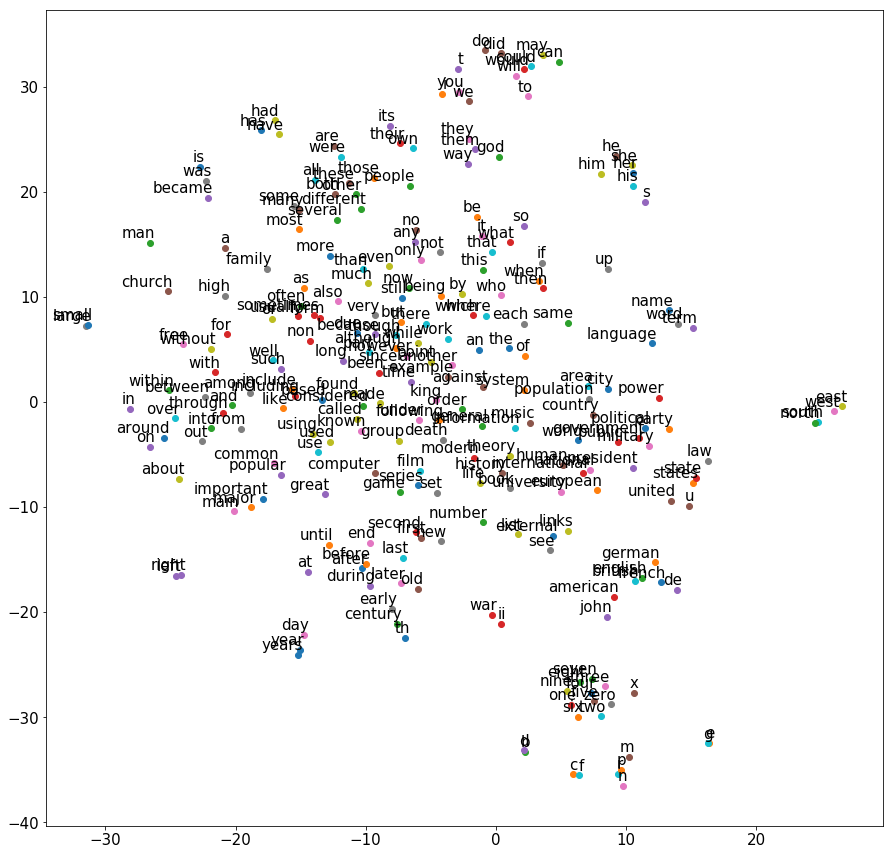

In [568]:
import random
tsne = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000)
num_points = 250

random_points = [index_to_word[i] for i in range(1, num_points+1)]  # random.sample(model_words,num_points)
random_points_mtx = np.array([model[word] for word in random_points])

two_d_embeddings = tsne.fit_transform(random_points_mtx)

plt.figure(figsize=(15,15))

for i, label in enumerate(random_points):
    x, y = two_d_embeddings[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points",
                   ha="right", va="bottom")
plt.show()